In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
!pip install shap
!pip install bayesian-optimization
!pip install lightgbm
!pip install imblearn


In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

train = pd.read_csv('/gdrive/My Drive/Data/train.csv', index_col=0)
test = pd.read_csv('/gdrive/My Drive/Data/test.csv', index_col=0)
sample_submission = pd.read_csv('/gdrive/My Drive/Data/sample_submission.csv', index_col=0)
scaler = RobustScaler(quantile_range=(5.0, 95.0))

column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))
train.drop("type",axis = 1,inplace=True)

In [32]:
train_yk = train[["type_num","fiberID"]]
train1 = train.drop(["type_num","fiberID"],axis=1)
feature_col = train1.columns
train_k = train1[train1[feature_col] < -10000]
train_k1 = train1[train1[feature_col] > 10000]
pre_index1 = set(train_k.dropna(how="all",axis=0).index)
pre_index2 = set(train_k1.dropna(how="all",axis=0).index)
pre_index = list(pre_index1|pre_index2)
train1 = train1.drop(pre_index,axis=0).reset_index(drop=True)
train_yk = train_yk.drop(pre_index,axis=0).reset_index(drop=True)
train = pd.concat([train_yk,train1[feature_col]],axis=1)
train.describe()

,type_num,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000,199967.000000
mean,8.877350,360.836078,20.984973,19.863238,19.279634,18.877026,18.613031,21.174863,20.089881,19.504901,19.086965,18.827800,20.715580,19.592849,18.971819,18.603406,18.459532,20.732552,19.532357,18.940937,18.521145,18.277743
std,4.624125,225.310377,2.880537,2.301702,4.428152,2.102323,1.778074,2.182445,1.847010,1.708607,1.626581,1.759590,6.106694,5.222008,14.852074,2.755426,20.555984,2.188645,1.964422,1.862759,1.798748,1.869158
min,0.000000,1.000000,-501.529124,-335.608609,-1276.171892,-30.711890,-106.927107,-68.798881,-8.294703,-14.662435,10.646672,-139.831165,-1131.081339,-1581.627834,-4370.038636,-654.195115,-789.601838,3.444448,8.686690,5.781584,5.004407,4.460086
25%,6.000000,174.000000,19.652851,18.701797,18.048841,17.748056,17.425874,19.941031,18.903314,18.259501,17.903940,17.606495,19.248076,18.114223,17.480113,17.050560,16.805079,19.266546,18.076352,17.423680,16.977890,16.705957
50%,8.000000,349.000000,20.871565,19.904295,19.454561,19.044046,18.611941,21.049274,20.069228,19.631763,19.189052,18.711133,20.366919,19.586785,19.182951,18.693606,18.174819,20.406944,19.547753,19.143324,18.641862,18.101187
75%,11.000000,526.000000,22.160432,21.150447,20.515948,20.073539,19.883862,22.337701,21.385940,20.773911,20.331480,20.133205,21.797480,21.004425,20.457454,20.019128,19.807647,21.992857,20.962215,20.408122,19.968846,19.819565
max,18.000000,1000.000000,368.939515,478.440761,923.580805,585.370349,115.830481,274.083693,68.509385,32.574603,42.002047,173.583776,1452.080803,773.346459,1705.906184,219.701423,8647.360709,49.487277,66.589958,35.102312,45.783550,61.597879


In [33]:
train2 = train[["fiberID","type_num"]]
train2["count"] =1
train2_g = train2.groupby(["fiberID","type_num"]).count().unstack("type_num")
train2_g.fillna(0,inplace=True)
for i in range(train2_g.shape[0]):
    for j in range(train2_g.shape[1]):
        if train2_g.iloc[i,j]!=0:
          if train2_g.iloc[i,j]>40:
            train2_g.iloc[i,j] = 4
          elif train2_g.iloc[i,j]>20:
            train2_g.iloc[i,j] = 3
          elif train2_g.iloc[i,j]>5:
            train2_g.iloc[i,j] = 2
          else:
            train2_g.iloc[i,j]= 1
train2_g.columns = sample_submission.columns
train2_g = train2_g.reset_index()

train = train.reset_index().merge(train2_g,on="fiberID").set_index("index").sort_index().drop("fiberID",axis=1)
test = test.reset_index().merge(train2_g,on="fiberID").set_index("id").sort_index().drop("fiberID",axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
train_x = train.drop('type_num', axis=1)
train_y = train['type_num']
test_x = test

In [0]:
sc_col = train_x.iloc[:,:20].columns
not_col = train_x.columns.difference(sc_col)
tr_ind =  train_x.index
te_ind = test_x.index

In [0]:
train_x1 = pd.DataFrame()
test_x1 = pd.DataFrame()
for i in sc_col:
    train_x1[i] = train_x[i]-train_x[i].min()+50
    test_x1[i] = test_x[i]-train_x[i].min()+50
train_x1 = np.log(train_x1)
test_x1 = np.log(test_x1)

In [37]:
train_x1.shape

(199967, 20)

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_x_sc = scaler.fit_transform(train_x1[sc_col])
test_x_sc = scaler.transform(test_x1[sc_col])
train_x_sc =  pd.DataFrame(train_x_sc,columns = sc_col,index = tr_ind)
test_x_sc =  pd.DataFrame(test_x_sc,columns = sc_col,index = te_ind)

In [0]:
# for i in sc_col:
#     train_x_sc[i+"_x2"] = train_x_sc[i]**2
#     train_x_sc[i+"_x3"] = train_x_sc[i]**3

train_x = pd.concat([train_x_sc,train_x[not_col]],axis=1)
test_x = pd.concat([test_x_sc,test_x[not_col]],axis=1)

In [0]:
test_x

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.2, random_state=42)

for train_index, test_index in split.split(train_x, train_y):
    x_train, y_train = train_x.loc[train_index], train_y[train_index]
    x_val, y_val = train_x.loc[test_index] , train_y[test_index]

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.2, random_state=42)

for train_index, test_index in split.split(train_x1, train_y):
    x_train, y_train = train_x1.loc[train_index], train_y[train_index]
    x_val, y_val = train_x1.loc[test_index] , train_y[test_index]

In [41]:
import lightgbm as lgb
lgb_clf1 = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=50, max_depth=-1, learning_rate=0.005, 
                             n_estimators=3000, subsample_for_bin=300000, objective='multiclass', min_split_gain=0.2, reg_alpha = 0.1, 
                             min_child_weight=5e-2, min_child_samples=12,n_jobs=-1, random_state=42,)
lgb_model1 = lgb_clf1.fit(x_train, y_train, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

Training until validation scores don't improve for 50 rounds.
[200]	valid_0's multi_logloss: 0.903577
[400]	valid_0's multi_logloss: 0.565866
[600]	valid_0's multi_logloss: 0.432617
[800]	valid_0's multi_logloss: 0.370824
[1000]	valid_0's multi_logloss: 0.336084
[1200]	valid_0's multi_logloss: 0.313517
[1400]	valid_0's multi_logloss: 0.296962
[1600]	valid_0's multi_logloss: 0.284424
[1800]	valid_0's multi_logloss: 0.274285
[2000]	valid_0's multi_logloss: 0.265717
[2200]	valid_0's multi_logloss: 0.258305
[2400]	valid_0's multi_logloss: 0.251458
[2600]	valid_0's multi_logloss: 0.245443
[2800]	valid_0's multi_logloss: 0.239601
[3000]	valid_0's multi_logloss: 0.234155
Did not meet early stopping. Best iteration is:
[3000]	valid_0's multi_logloss: 0.234155


In [0]:
lgb_model1.learning_rate = 0.002
lgb.model1.n_estimators=3000
lgb_model1 = lgb_clf1.fit(train_x, train_y, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

In [42]:
from sklearn.externals import joblib
joblib.dump(lgb_model1,'/gdrive/My Drive/Data/lgb.pkl')

['/gdrive/My Drive/Data/lgb.pkl']

In [0]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
encoder1 = OneHotEncoder()
y_en = encoder1.fit_transform(np.array(y_val).reshape(-1,1))

In [24]:
y_preds = lgb_clf1.predict_proba(x_val)
log_loss(y_en.toarray(),y_preds)

0.26132239310549693

In [0]:
y_test = lgb_model1.predict_proba(test_x)
submission = pd.DataFrame(data=y_test, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('/gdrive/My Drive/Data/submission7.csv', index=True)

[Text(0, 0, 'psfMag_z'),
 Text(0, 0, 'modelMag_u'),
 Text(0, 0, 'modelMag_z'),
 Text(0, 0, 'psfMag_u'),
 Text(0, 0, 'fiberMag_u'),
 Text(0, 0, 'psfMag_g'),
 Text(0, 0, 'petroMag_u'),
 Text(0, 0, 'fiberMag_g'),
 Text(0, 0, 'psfMag_r'),
 Text(0, 0, 'petroMag_z'),
 Text(0, 0, 'fiberMag_z'),
 Text(0, 0, 'modelMag_g'),
 Text(0, 0, 'psfMag_i'),
 Text(0, 0, 'fiberMag_i'),
 Text(0, 0, 'fiberMag_r'),
 Text(0, 0, 'petroMag_g'),
 Text(0, 0, 'modelMag_i'),
 Text(0, 0, 'petroMag_i'),
 Text(0, 0, 'petroMag_r'),
 Text(0, 0, 'modelMag_r'),
 Text(0, 0, 'QSO'),
 Text(0, 0, 'GALAXY'),
 Text(0, 0, 'SERENDIPITY_DISTANT'),
 Text(0, 0, 'STAR_CARBON'),
 Text(0, 0, 'STAR_WHITE_DWARF'),
 Text(0, 0, 'SERENDIPITY_RED'),
 Text(0, 0, 'SERENDIPITY_BLUE'),
 Text(0, 0, 'STAR_SUB_DWARF'),
 Text(0, 0, 'STAR_BROWN_DWARF'),
 Text(0, 0, 'REDDEN_STD'),
 Text(0, 0, 'SPECTROPHOTO_STD'),
 Text(0, 0, 'ROSAT_D'),
 Text(0, 0, 'SERENDIPITY_FIRST'),
 Text(0, 0, 'STAR_RED_DWARF'),
 Text(0, 0, 'STAR_CATY_VAR'),
 Text(0, 0, 'STAR_BHB'

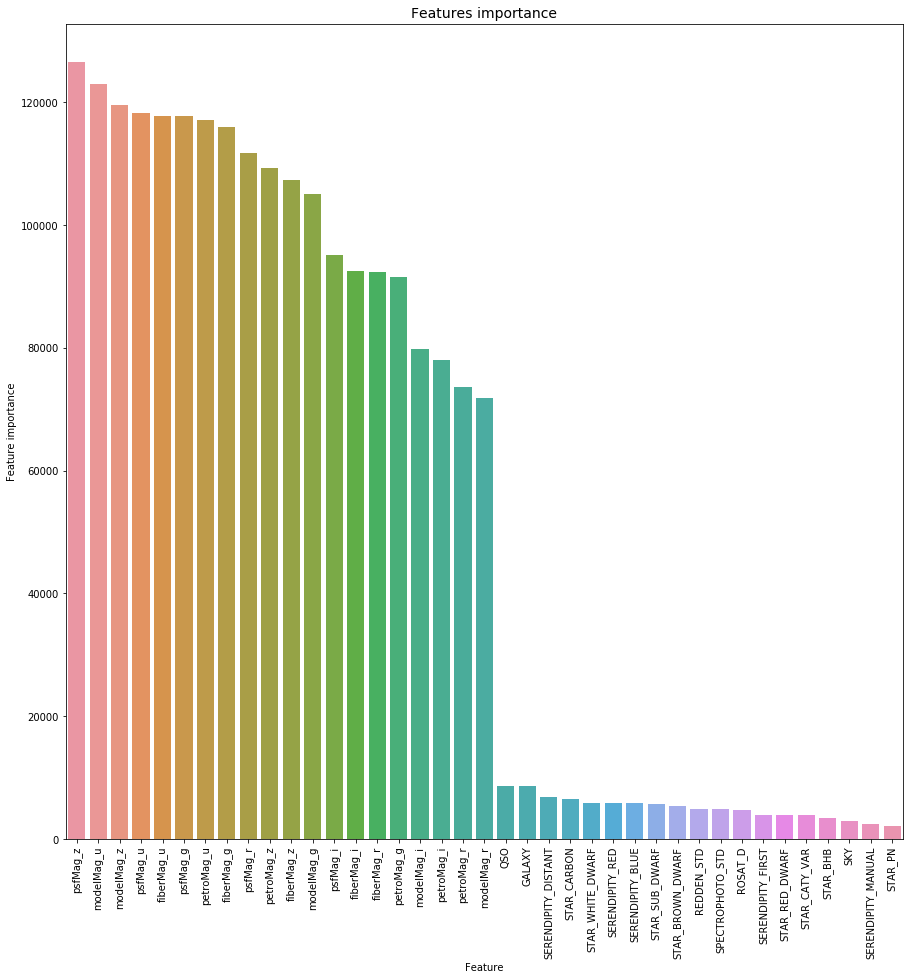

In [43]:
tmp = pd.DataFrame({'Feature': x_train.columns, 'Feature importance': lgb_model1.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (15,15))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

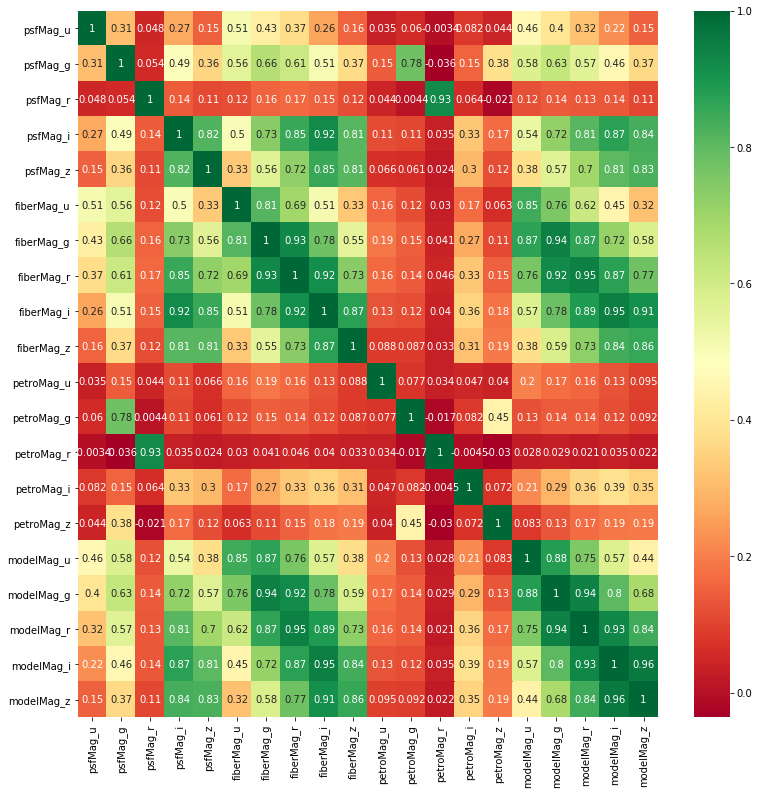

In [46]:
corrmat = train_x_sc.corr()
plt.figure(figsize=(13,13))
g = sns.heatmap(corrmat,annot=True,cmap="RdYlGn")

In [0]:
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority',random_state=42,ratio = 0.3)
x_sm, y_sm = smote.fit_sample(x_train,y_train)
lgb_clf1 = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=70, max_depth=-1, learning_rate=0.005, 
                             n_estimators=5000, subsample_for_bin=300000, objective='binary', min_split_gain=0.2, reg_alpha = 0.1 
                             min_child_weight=5e-2, min_child_samples=12,n_jobs=-1, random_state=42,class_weight=True,)
lgb_model1 = lgb_clf1.fit(x_sm,y_sm)

In [0]:
from imblearn.under_sampling import TomekLinks
X_samp, y_samp = TomekLinks(random_state=0).fit_sample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
X_samp.shape

(149685, 20)

In [0]:
lgb_clf2 = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=45, max_depth=-1, learning_rate=0.002, 
                             n_estimators=8000, subsample_for_bin=300000, objective='multiclass', min_split_gain=0.1,
                             min_child_weight=5e-2, min_child_samples=13,n_jobs=-1, random_state=42,)
lgb_model2 = lgb_clf2.fit(x_train, y_train, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

Training until validation scores don't improve for 50 rounds.
[200]	valid_0's multi_logloss: 1.43764
[400]	valid_0's multi_logloss: 1.07652
[600]	valid_0's multi_logloss: 0.862799
[800]	valid_0's multi_logloss: 0.725324
[1000]	valid_0's multi_logloss: 0.633316
[1200]	valid_0's multi_logloss: 0.570117
[1400]	valid_0's multi_logloss: 0.525929
[1600]	valid_0's multi_logloss: 0.494544
[1800]	valid_0's multi_logloss: 0.471987
[2000]	valid_0's multi_logloss: 0.454958
[2200]	valid_0's multi_logloss: 0.441909
[2400]	valid_0's multi_logloss: 0.432041
[2600]	valid_0's multi_logloss: 0.424384
[2800]	valid_0's multi_logloss: 0.418431
[3000]	valid_0's multi_logloss: 0.413718
[3200]	valid_0's multi_logloss: 0.409885
[3400]	valid_0's multi_logloss: 0.406812
[3600]	valid_0's multi_logloss: 0.404237
[3800]	valid_0's multi_logloss: 0.402101
[4000]	valid_0's multi_logloss: 0.400276
[4200]	valid_0's multi_logloss: 0.398711
[4400]	valid_0's multi_logloss: 0.397411
[4600]	valid_0's multi_logloss: 0.396248
[

KeyboardInterrupt: ignored

In [0]:
lgb_model2.fit(X_samp, y_samp)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.003, max_depth=-1,
               min_child_samples=15, min_child_weight=0.05, min_split_gain=0.2,
               n_estimators=1000, n_jobs=-1, num_leaves=50,
               objective='multiclass', random_state=42, reg_alpha=0.1,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=400000, subsample_freq=0)

In [0]:
y_pred2 = lgb_model2.predict_proba(x_val)
log_loss(y_en.toarray(),y_pred2)

0.7613299763630202